In [1]:
# Import libraries
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

In [3]:
#### Data Cleaning
movies = pd.read_csv("/Users/talmageanderson/Desktop/Stat_486/mini1 data/movies.csv")

# Calculate the number of stars based on the number of '(' characters
movies['num_stars'] = movies['stars'].apply(lambda x: x.count('('))

# Convert all values in 'runtime' to strings, then remove ' min'
movies['runtime'] = movies['runtime'].astype(str).str.replace(' min', '', regex=False)

# Convert the cleaned 'runtime' column to numeric
movies['runtime'] = pd.to_numeric(movies['runtime'], errors='coerce')

# Fill missing values (if any) with the median or other appropriate value
movies['runtime'] = movies['runtime'].fillna(movies['runtime'].median())

# Ensure 'votes' column is treated as strings, then remove commas
movies['votes'] = movies['votes'].astype(str).str.replace(',', '', regex=True)

# Convert the cleaned 'votes' column back to numeric
movies['votes'] = pd.to_numeric(movies['votes'], errors='coerce')

# Fill missing values (if any) with 0 or an appropriate default
movies['votes'] = movies['votes'].fillna(0)

# Remove '$' and 'M', then convert to numeric and multiply by 1,000,000
movies['gross_earn'] = (
    movies['gross_earn']
    .str.replace('$', '', regex=False)  # Remove dollar sign
    .str.replace('M', '', regex=False)  # Remove 'M'
    .astype(float)                      # Convert to float
    * 1_000_000                         # Multiply by 1,000,000
)

# Handle missing values (if any)
movies['gross_earn'] = movies['gross_earn'].fillna(0)

# Ensure all values in 'genre' are strings; replace NaN with an empty string
movies['genre'] = movies['genre'].fillna('').astype(str)

# 1. Split genres and create a list of all unique genres
movies['genre_list'] = movies['genre'].apply(lambda x: [g.strip() for g in x.split(',') if g])

# 2. Create a set of all unique genres
unique_genres = set(g for genres in movies['genre_list'] for g in genres)

# 3. One-hot encode genres
for genre in unique_genres:
    movies[f'genre_{genre}'] = movies['genre_list'].apply(lambda x: 1 if genre in x else 0)

# 4. Drop the extra columns
movies = movies.drop(columns=['genre_list', 'poster'])

,title,certificate,runtime,genre,rating,about,director,stars,votes,gross_earn,...,genre_Drama,genre_Comedy,genre_Adventure,genre_History,genre_Family,genre_Romance,genre_Musical,genre_Sci-Fi,genre_War,genre_Western
0,The Shawshank Redemption,15,142.0,Drama,9.3,Two imprisoned men bond over a number of years...,Frank Darabont,"('Tim Robbins',), ('Morgan Freeman',), ('Bob G...",2626905,28340000.0,...,1,0,0,0,0,0,0,0,0,0
1,The Dark Knight,12A,152.0,"Action, Crime, Drama",9.0,When the menace known as the Joker wreaks havo...,Christopher Nolan,"('Christian Bale',), ('Heath Ledger',), ('Aaro...",2598173,534860000.0,...,1,0,0,0,0,0,0,0,0,0
2,Inception,12A,148.0,"Action, Adventure, Sci-Fi",8.8,A thief who steals corporate secrets through t...,Christopher Nolan,"('Leonardo DiCaprio',), ('Joseph Gordon-Levitt...",2304062,292580000.0,...,0,0,1,0,0,0,0,1,0,0
3,Fight Club,18,139.0,Drama,8.8,An insomniac office worker and a devil-may-car...,David Fincher,"('Brad Pitt',), ('Edward Norton',), ('Meat Loa...",2071088,37030000.0,...,1,0,0,0,0,0,0,0,0,0
4,Pulp Fiction,18,154.0,"Crime, Drama",8.9,"The lives of two mob hitmen, a boxer, a gangst...",Quentin Tarantino,"('John Travolta',), ('Uma Thurman',), ('Samuel...",2011013,107930000.0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd

# Assuming your dataset is a pandas DataFrame named 'movies'
# Preprocessing
categorical_features = ['genre', 'director', 'stars']
numerical_features = ['runtime', 'rating', 'votes']

# Separate features and target
X = movies[categorical_features + numerical_features]
y = movies['gross_earn']

# Preprocess categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# Scale the target variable
target_scaler = MinMaxScaler()

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess features
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Scale the target variable
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

# Define the feedforward neural network
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
input_dim = X_train_tensor.shape[1]
model = FeedForwardNN(input_dim)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reduced learning rate

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

# Evaluation
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_tensor)
    test_loss = criterion(y_test_pred, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

# Inverse transform the predictions and the test target for interpretation
y_test_pred_original = target_scaler.inverse_transform(y_test_pred.numpy())
y_test_original = target_scaler.inverse_transform(y_test_tensor.numpy())


Epoch 10/100, Loss: 0.0138
Epoch 20/100, Loss: 0.0121
Epoch 30/100, Loss: 0.0105
Epoch 40/100, Loss: 0.0090
Epoch 50/100, Loss: 0.0077
Epoch 60/100, Loss: 0.0065
Epoch 70/100, Loss: 0.0055
Epoch 80/100, Loss: 0.0046
Epoch 90/100, Loss: 0.0039
Epoch 100/100, Loss: 0.0033
Test Loss: 0.0032


The earning values are scaled down

Why Are Losses Small?
Target Normalization: After scaling the target variable (gross_earn), the actual magnitude of errors is reduced because the values are now small.

In [7]:
# COMPARISON OF OUTPUTS

# Inverse transform predictions and true values
y_test_pred_original = target_scaler.inverse_transform(y_test_pred.numpy())
y_test_original = target_scaler.inverse_transform(y_test_tensor.numpy())

# Calculate metrics like Mean Absolute Error (MAE) or Root Mean Squared Error (RMSE)
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(y_test_original, y_test_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_test_pred_original))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

Mean Absolute Error: 32519828.0
Root Mean Squared Error: 53118736.0


In [8]:
# Display some example predictions
comparison = pd.DataFrame({
    "Actual": y_test_original.flatten(),
    "Predicted": y_test_pred_original.flatten()
})
print(comparison.head(10))

        Actual   Predicted
0   47810000.0  17696756.0
1   71730000.0  23782508.0
2   50750000.0  20777826.0
3   53260000.0  33323538.0
4  100320000.0  34319808.0
5   66210004.0  94938136.0
6   23220000.0  27537890.0
7   38090000.0  25194362.0
8    2190000.0  12686860.0
9   84750000.0   8840044.0


In [13]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_original, y_test_pred_original)

# Display metrics
print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R² Score: {r2}")

Mean Absolute Error: 32519828.0
Root Mean Squared Error: 53118736.0
R² Score: 0.1928994059562683


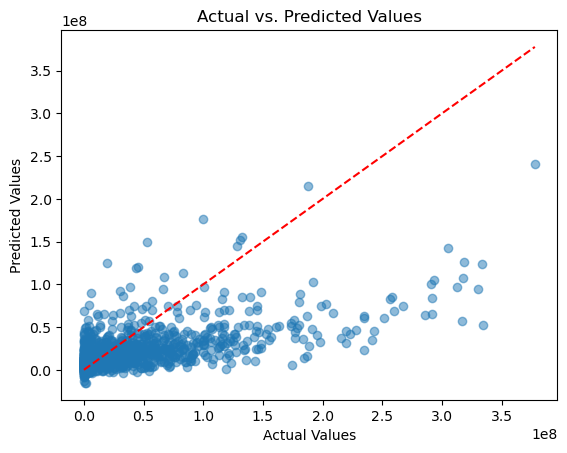

In [10]:
## Making graphs for final report

import matplotlib.pyplot as plt

plt.scatter(y_test_original, y_test_pred_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()], 'r--')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

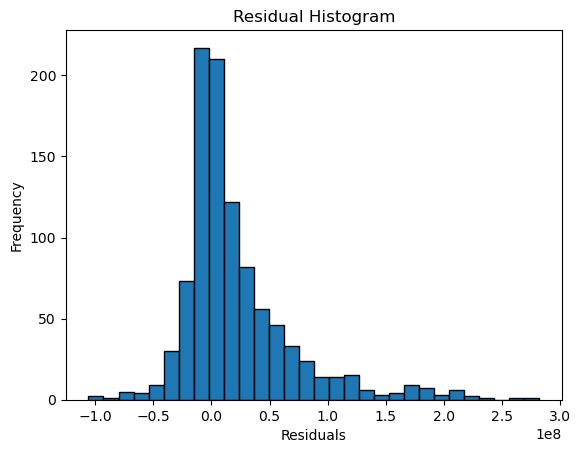

In [9]:
residuals = y_test_original.flatten() - y_test_pred_original.flatten()
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Residual Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# the residuals should be normally distributed and centered around zero.